## Neural Network: Finetuning, regularization and debiasing

Validation Results:
Accuracy: 0.780
Precision: 0.664
Recall: 0.696
F1: 0.680
AUC: 0.802


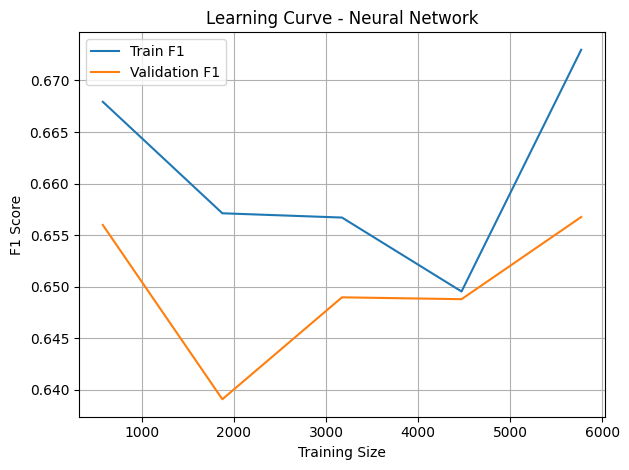

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params,Timestamp
0,Logistic Regression,0.751,0.607,0.737,0.666,0.800,"{'clf__C': 0.01, 'clf__class_weight': 'balanced'}",NaN
1,AdaBoost,0.777,0.673,0.650,0.661,0.806,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",NaN
2,Neural Network,0.776,0.686,0.613,0.648,0.805,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",NaN
3,Neural Network,0.769,0.662,0.636,0.649,0.802,"{'clf__activation': 'relu', 'clf__alpha': 0.01...",NaN
4,Logistic Regression,0.751,0.605,0.741,0.666,0.800,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",NaN
5,AdaBoost,0.777,0.673,0.650,0.661,0.806,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",NaN
6,Neural Network,0.780,0.664,0.696,0.680,0.802,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",NaN
7,AdaBoost,0.777,0.673,0.650,0.661,0.806,"{'clf__learning_rate': 0.5, 'clf__n_estimators...",NaN
8,Logistic Regression,0.751,0.605,0.741,0.666,0.800,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",NaN
9,Logistic Regression,0.751,0.605,0.741,0.666,0.800,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",2025-04-07T20:53:31.323653


In [9]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# Load preprocessed data and pipeline
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Feature preparation
X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)
selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Data split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define NN pipeline & GridSearch
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(max_iter=300, random_state=42))
])

param_grid = {
    "clf__alpha": [0.0001, 0.001, 0.01],
    "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
    "clf__activation": ["relu", "tanh"],
    "clf__learning_rate_init": [0.0005, 0.001, 0.005],
    "clf__learning_rate": ['constant', 'adaptive'],
    "clf__early_stopping": [True],
    "clf__max_iter": [500]
}


grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# Evaluation
y_proba = best_model.predict_proba(X_val)[:, 1]
y_pred = best_model.predict(X_val)
print("Validation Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_pred):.3f}")
print(f"F1: {f1_score(y_val, y_pred):.3f}")
print(f"AUC: {roc_auc_score(y_val, y_proba):.3f}")

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=cv, scoring="f1", train_sizes=np.linspace(0.1, 1.0, 5))
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation F1")
plt.title("Learning Curve - Neural Network")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.tight_layout()
os.makedirs("../reports/02_modeling/tuning", exist_ok=True)
plt.savefig("../reports/02_modeling/tuning/learning_curve_NN_finetuned.png")
plt.show()

# === Logging dynamic results to CSV ===

model_name = "Neural Network"

# Prepare log path
log_file = Path("../reports/02_modeling/tuning/model_validation_comparison_log.csv")
log_file.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

# Prepare result row dynamically
result_row = {
    "Model": model_name,
    "Accuracy": round(accuracy_score(y_val, y_pred), 3),
    "Precision": round(precision_score(y_val, y_pred), 3),
    "Recall": round(recall_score(y_val, y_pred), 3),
    "F1 Score": round(f1_score(y_val, y_pred), 3),
    "AUC": round(roc_auc_score(y_val, y_proba), 3),
    "Best Params": str(grid.best_params_),
    "Timestamp": datetime.now().isoformat()
}

# Append to log file
if log_file.exists():
    df_log = pd.read_csv(log_file)
else:
    df_log = pd.DataFrame(columns=result_row.keys())

df_log = pd.concat([df_log, pd.DataFrame([result_row])], ignore_index=True)
df_log.to_csv(log_file, index=False)
df_log